# US Election 2020

In [1]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score

In [2]:
# Step 1: Unzip and load the dataset
zip_file_path = 'US Election 2020.zip'  # Path to the zip file
extracted_folder = 'US_Election_Data/'  # Folder to extract files

# Unzipping the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

# Load the CSV file into a DataFrame
csv_file_path = extracted_folder + 'US_Election_dataset_v1.csv'
election_data = pd.read_csv(csv_file_path)

First few rows of the dataset:
                Unnamed: 0          county    state  2020 Democrat vote raw  \
0  Autauga County, Alabama  Autauga County  Alabama                    7503   
1  Baldwin County, Alabama  Baldwin County  Alabama                   24578   
2  Barbour County, Alabama  Barbour County  Alabama                    4816   
3     Bibb County, Alabama     Bibb County  Alabama                    1986   
4   Blount County, Alabama   Blount County  Alabama                    2640   

   2020 Democrat vote %  2020 Republican vote raw  2020 Republican vote %  \
0                 27.02                     19838                   71.44   
1                 22.41                     83544                   76.17   
2                 45.79                      5622                   53.45   
3                 20.70                      7525                   78.43   
4                  9.57                     24711                   89.57   

   2020 other vote raw  2020 ot

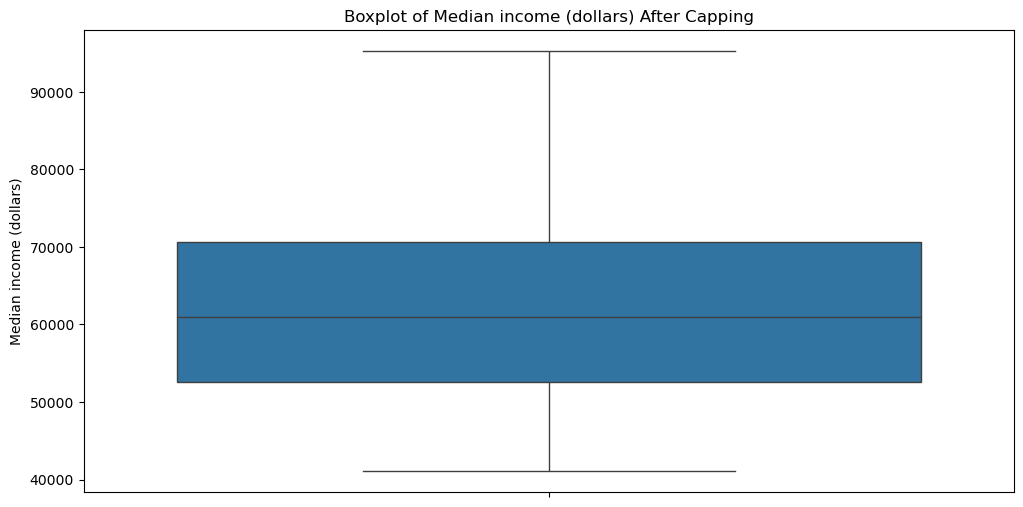


Number of duplicate rows after cleaning:
0

Data types after conversion of education columns:
Population with less than 9th grade education              float64
Population with 9th to 12th grade education, no diploma    float64
High School graduate and equivalent                        float64
Some College,No Degree                                     float64
Associates Degree                                          float64
Bachelors Degree                                           float64
Graduate or professional degree                            float64
dtype: object

First few rows after cleaning education columns:
   Population with less than 9th grade education  \
0                                            1.7   
1                                            2.0   
2                                            7.3   
3                                            6.4   
4                                            7.1   

   Population with 9th to 12th grade education, no diploma 

In [3]:
# Step 2: Inspect the data
print("First few rows of the dataset:")
print(election_data.head())  # Preview the first few rows

# Step 3: Clean column names to remove any leading/trailing spaces
election_data.columns = election_data.columns.str.strip()

# Step 4: Check for missing values
print("\nMissing values in the dataset:")
print(election_data.isnull().sum())  # Count missing values per column

# Step 5: Check for duplicates
print("\nNumber of duplicate rows:")
print(election_data.duplicated().sum())  # Count duplicate rows

# Step 6: Handle outliers (capping)
column_to_cap = 'Median income (dollars)'

# Clean the column by removing non-numeric characters (e.g., commas, '$')
election_data[column_to_cap] = election_data[column_to_cap].replace({',': '', '$': ''}, regex=True)

# Convert the column to numeric
election_data[column_to_cap] = pd.to_numeric(election_data[column_to_cap], errors='coerce')

# Calculate the 5th and 95th percentiles
lower_bound = election_data[column_to_cap].quantile(0.05)
upper_bound = election_data[column_to_cap].quantile(0.95)

# Cap the outliers
election_data[column_to_cap] = np.clip(election_data[column_to_cap], lower_bound, upper_bound)

# Verify outliers are capped
plt.figure(figsize=(12, 6))
sns.boxplot(data=election_data[column_to_cap])
plt.title(f'Boxplot of {column_to_cap} After Capping')
plt.show()

# Step 7: Remove duplicate rows (if any)
election_data.drop_duplicates(inplace=True)

# Verify duplicates are removed
print("\nNumber of duplicate rows after cleaning:")
print(election_data.duplicated().sum())

# Step 8: Convert percentage columns to numeric for educational data
education_columns = ['Population with less than 9th grade education',
                     'Population with 9th to 12th grade education, no diploma', 
                     'High School graduate and equivalent', 
                     'Some College,No Degree', 'Associates Degree', 
                     'Bachelors Degree', 'Graduate or professional degree']

# Convert percentage columns to numeric by removing the '%' and converting to float
for col in education_columns:
    election_data[col] = election_data[col].replace('%', '', regex=True).astype(float)

# Verify data types after conversion
print("\nData types after conversion of education columns:")
print(election_data[education_columns].dtypes)

# Optional: Inspect the first few rows of the cleaned columns
print("\nFirst few rows after cleaning education columns:")
print(election_data[education_columns].head())


In [4]:
# Step 9: Create new features
# Create the 'total_votes' column by summing the relevant columns
election_data['total_votes'] = election_data['2020 Democrat vote raw'] + election_data['2020 Republican vote raw'] + election_data['2020 other vote raw']

# Calculate the 'vote share' for each party
election_data['vote_share_democrat'] = (election_data['2020 Democrat vote raw'] / election_data['total_votes']) * 100
election_data['vote_share_republican'] = (election_data['2020 Republican vote raw'] / election_data['total_votes']) * 100
election_data['vote_share_other'] = (election_data['2020 other vote raw'] / election_data['total_votes']) * 100

# Create a new feature for the difference between the Democrat and Republican vote share
election_data['vote_share_diff'] = election_data['vote_share_democrat'] - election_data['vote_share_republican']

# Verify the new features
print("\nData with new features:")
print(election_data[['vote_share_democrat', 'vote_share_republican', 'vote_share_other', 'vote_share_diff']].head())



Data with new features:
   vote_share_democrat  vote_share_republican  vote_share_other  \
0            27.018365              71.436802          1.544833   
1            22.409030              76.171373          1.419597   
2            45.788173              53.451226          0.760601   
3            20.698280              78.426264          0.875456   
4             9.569378              89.571553          0.859069   

   vote_share_diff  
0       -44.418437  
1       -53.762343  
2        -7.663054  
3       -57.727983  
4       -80.002175  


In [5]:
# Step 10: Normalize numerical columns if needed
scaler = MinMaxScaler()
numerical_columns = election_data.select_dtypes(include=[np.number]).columns

# Apply MinMax scaling
election_data[numerical_columns] = scaler.fit_transform(election_data[numerical_columns])

# Verify normalized data
print("\nNormalized Data (first 5 rows):")
print(election_data[numerical_columns].head())

# Step 11: Final inspection
print("\nFinal cleaned and preprocessed data:")
print(election_data.head())  # Preview the cleaned data


Normalized Data (first 5 rows):
   2020 Democrat vote raw  2020 Democrat vote %  2020 Republican vote raw  \
0                0.002476              0.258033                  0.017317   
1                0.008113              0.208324                  0.072930   
2                0.001589              0.460427                  0.004907   
3                0.000654              0.189886                  0.006568   
4                0.000870              0.069873                  0.021571   

   2020 Republican vote %  2020 other vote raw  2020 other vote %  \
0                0.731204             0.004819           0.118462   
1                0.782595             0.017489           0.109231   
2                0.535745             0.000899           0.058462   
3                0.807149             0.000944           0.067692   
4                0.928183             0.002662           0.066154   

   Population with less than 9th grade education  \
0                                    

In [6]:
# Step 8: One-Hot Encoding for the 'state' column (if it exists)
if 'state' in election_data.columns:
    election_data = pd.get_dummies(election_data, columns=['state'], drop_first=True)
else:
    print("The 'state' column is not found for encoding.")

# Step 9: Feature selection and data preprocessing
# Selecting relevant features for the model
features = ['Population with less than 9th grade education', 'Population with 9th to 12th grade education, no diploma',
            'High School graduate and equivalent', 'Some College,No Degree', 'Associates Degree',
            'Bachelors Degree', 'Graduate or professional degree', 'Gini Index', 'Median income (dollars)',
            'Total Population', 'Hispanic or Latino percentage', 'NH-White percentage', 'NH-Black percentage', 
            'NH-American Indian and Alaska Native percentage', 'NH-Asian percentage', 'NH-Native Hawaiian and Other Pacific Islander percentage',
            'NH-Some Other Race percentage', 'NH-Two or More Races percentage', 'Percentage engaged in Management, business, science, and arts occupations',
            'Percentage engaged in Service Occupations', 'Percentage engaged in Sales and Office',
            'Percentage engaged in Resources and Construction', 'Percentage engaged in Transportation']

# Step 10: Create the target variable
target = 'vote_share_democrat'  # We are predicting the Democrat vote share

# Step 11: Split the data into features (X) and target (y)
X = election_data[features]
y = election_data[target]

# Step 12: Clean the percentage columns (remove '%' and convert to numeric)
percentage_columns = ['Hispanic or Latino percentage', 'NH-White percentage', 'NH-Black percentage',
                      'NH-American Indian and Alaska Native percentage', 'NH-Asian percentage',
                      'NH-Native Hawaiian and Other Pacific Islander percentage', 
                      'NH-Some Other Race percentage', 'NH-Two or More Races percentage']

# Convert percentage columns to numeric and remove percentage sign
for col in percentage_columns:
    X[col] = X[col].replace('%', '', regex=True).astype(float)

# Step 13: Split the data into training and testing sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 14: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify the data before moving on to the modeling steps
print("\nScaled Features (first 5 rows):")
print(X_train_scaled[:5])


Scaled Features (first 5 rows):
[[-0.04479465  0.66225718  1.10501547 -2.58613684 -0.58157767 -0.31196618
   0.71801043  1.27260835  0.14779216 -0.18583491 -0.3764706   0.51879735
  -0.19624741 -0.22146662  0.16030142 -0.13381817 -0.20441315 -0.58822623
   0.99741254 -0.60955888  0.59545303 -0.76242635 -0.60859088]
 [-0.72532965 -0.97244564  0.0762796  -0.10109733 -0.30846919  0.57800508
   0.63466579 -0.51322996  1.41190512  0.19265347  0.07428337  0.24771624
  -0.31014913 -0.22681662 -0.0532869  -0.11747128  0.19836068  0.14081178
   0.726816   -0.76550195 -0.37028344 -0.13055715 -0.13897108]
 [-0.13356008  0.35953444  0.94674841  0.25390832 -0.10363783 -1.15156171
  -0.34463374  0.58409238 -0.88345604 -0.25335647 -0.60039821  0.92314739
  -0.58336907 -0.17732907 -0.39035597 -0.16651193 -0.33867109  0.43020092
  -0.35147021 -0.20356917  0.32289326  0.77952311 -0.15938934]
 [-0.42944487 -1.36598521 -2.09989243 -2.10434346 -0.88882472  2.35794761
   3.90594294  1.124685    2.27848717 

C:\Users\milto\AppData\Local\Temp\ipykernel_15784\1216430713.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].replace('%', '', regex=True).astype(float)
C:\Users\milto\AppData\Local\Temp\ipykernel_15784\1216430713.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].replace('%', '', regex=True).astype(float)
C:\Users\milto\AppData\Local\Temp\ipykernel_15784\1216430713.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [7]:
# Step 1: Remove commas from columns that contain numeric values
columns_with_commas = ['Median income (dollars)', 'Mean income (dollars)', 'Total Population']  # Add any other columns with commas

for col in columns_with_commas:
    # Remove commas
    election_data[col] = election_data[col].replace({',': ''}, regex=True)
    # Convert to numeric, coercing errors to NaN if there's any invalid data
    election_data[col] = pd.to_numeric(election_data[col], errors='coerce')

# After this step, the columns will be cleaned, and all commas will be removed, making the values numeric.

# Step 2: Now, apply feature scaling (using StandardScaler) and split the data again
scaler = StandardScaler()

# Ensure the target variable is numeric
y = election_data['vote_share_democrat']  # Set this to the column you want to predict

# Feature selection (drop non-numerical columns)
X = election_data.drop(['Unnamed: 0', 'county', 'state', 'total_votes', 'vote_share_democrat'], axis=1, errors='ignore')

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Feature Scaling
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train the model (Linear Regression)
# Drop rows with missing values
X_train_clean = X_train.dropna()
X_test_clean = X_test.dropna()
y_train_clean = y_train[X_train_clean.index]  # Ensure y is aligned with the cleaned X
y_test_clean = y_test[X_test_clean.index]

# Step 2: Train the model (Linear Regression)
lr_model = LinearRegression()
lr_model.fit(X_train_clean, y_train_clean)

# Step 3: Predictions and evaluation (Linear Regression)
y_pred_lr = lr_model.predict(X_test_clean)

# Model Evaluation for Linear Regression
print("\nLinear Regression Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test_clean, y_pred_lr)}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test_clean, y_pred_lr))}")
print(f"R-squared (R2): {r2_score(y_test_clean, y_pred_lr)}")



Linear Regression Model Evaluation:
Mean Absolute Error (MAE): 2.8114985127688726e-11
Root Mean Squared Error (RMSE): 3.996247440979651e-11
R-squared (R2): 1.0


In [8]:
# Step 8: Train the model (Random Forest Regressor)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Step 9: Predictions and evaluation (Random Forest)
y_pred_rf = rf_model.predict(X_test_scaled)

# Model Evaluation for Random Forest Regressor
print("\nRandom Forest Model Evaluation:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred_rf)}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred_rf))}")
print(f"R-squared (R2): {r2_score(y_test, y_pred_rf)}")

# Step 10: Feature selection using RFE (Recursive Feature Elimination)
rfe = RFE(lr_model, n_features_to_select=10)
rfe.fit(X_train_scaled, y_train)

# Get the selected features based on RFE
selected_features = X.columns[rfe.support_]

print("\nSelected features using RFE:")
print(selected_features)

# Optional: Display feature rankings
print("\nFeature rankings (RFE):")
print(list(zip(X.columns, rfe.ranking_)))

# Step 11: Cross-validation score for Random Forest
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5)  # Use X_train_scaled
print(f"Cross-validation scores (Random Forest): {cv_scores}")
print(f"Average Cross-validation score: {cv_scores.mean()}")


Random Forest Model Evaluation:
Mean Absolute Error (MAE): 0.0003667281613384678
Root Mean Squared Error (RMSE): 0.0011638598420885046
R-squared (R2): 0.999955061774762

Selected features using RFE:
Index(['2020 Democrat vote %', '2020 Republican vote %',
       'Percentage engaged in Management, business, science, and arts occupations',
       'Percentage engaged in Service Occupations',
       'Percentage engaged in Sales and Office',
       'Percentage engaged in Resources and Construction',
       'Percentage engaged in Transportation', 'vote_share_republican',
       'vote_share_other', 'vote_share_diff'],
      dtype='object')

Feature rankings (RFE):
[('2020 Democrat vote raw', 21), ('2020 Democrat vote %', 1), ('2020 Republican vote raw', 20), ('2020 Republican vote %', 1), ('2020 other vote raw', 69), ('2020 other vote %', 2), ('Population with less than 9th grade education', 18), ('Population with 9th to 12th grade education, no diploma', 5), ('High School graduate and equiv

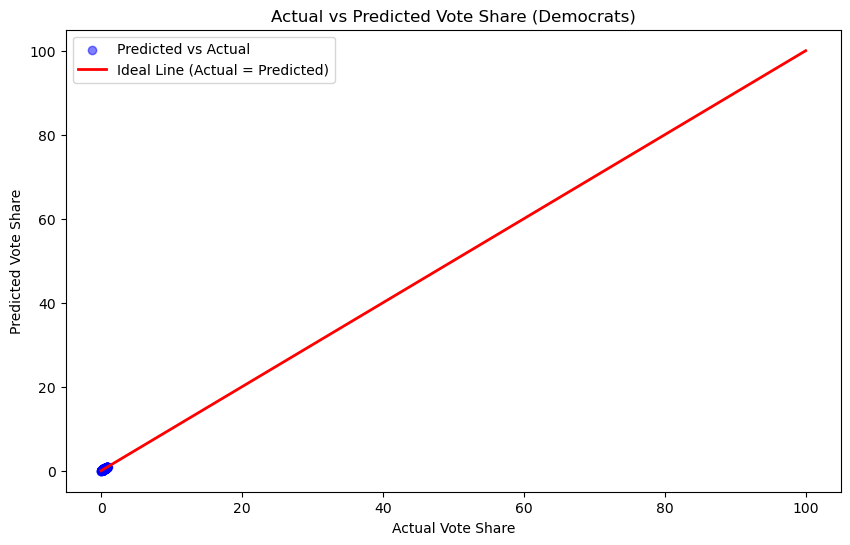

In [9]:
# Step 12: Final predictions and plotting
final_model = rf_model  # You can choose Linear Regression or Random Forest

# Final predictions on the test set
final_predictions = final_model.predict(X_test_scaled)

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, final_predictions, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.plot([0, 100], [0, 100], color='red', linewidth=2, label="Ideal Line (Actual = Predicted)")  # Ideal line
plt.title('Actual vs Predicted Vote Share (Democrats)')
plt.xlabel('Actual Vote Share')
plt.ylabel('Predicted Vote Share')
plt.legend(loc="best")
plt.show()

In [10]:
# It's possible that the model performance could be improved further. 
# The issue you're seeing, where the "Predicted vs Actual" plot shows small dots (indicating close clustering between predicted and actual values), could suggest that the model is overfitting or that the data cleaning process may not be fully optimized.

# Possible Issues to Address:
# Overfitting in the Model: A very high R-squared (close to 1.0) might indicate that the model is overfitting the training data. This could mean that it fits the noise or specific characteristics of the training data rather than generalizing well to the test data.
# Data Cleaning: While your data cleaning process is thorough, there may still be potential improvements. Specifically:
# Handling Outliers: Sometimes, a few extreme outliers can affect model performance. We’ve already capped the outliers for certain columns, but ensure that outliers in other columns are also addressed.
# Feature Engineering: The features you choose to include in the model are crucial. If there are redundant features or irrelevant columns, they can reduce the effectiveness of the model. On the other hand, missing key features that are highly predictive of the target could also limit model performance.
# Data Transformation: In addition to scaling numerical features, you could explore more advanced transformations like log transformations for skewed features or polynomial features if there’s reason to believe that relationships between features and the target are nonlinear.

# Steps to Improve Data Cleaning and Model Performance:

# Check for Outliers in All Columns: While you’ve capped outliers for the 'Median income (dollars)' column, make sure that outliers are not affecting other important features.
# Improve Feature Selection:
# You may want to use correlation analysis to check the relationship between features and the target variable. Features that are highly correlated with each other could be causing multicollinearity, which could impact the model's performance. Consider using Principal Component Analysis (PCA) or Variance Inflation Factor (VIF) to detect collinearity.
# Use Regularization: In case the model is overfitting, you could try Ridge or Lasso Regression, which add penalties to the coefficients of the features and can help reduce overfitting.
# Explore Polynomial Features: If the relationship between features and the target is nonlinear, polynomial features could help the model capture more complexity.
# Imputation & Handling Missing Values: While you’ve dropped missing values, consider using imputation techniques for numerical features. The way you handle missing data (either by dropping or imputing) can have a significant impact on the model’s ability to generalize.
# Cross-Validation: Implementing cross-validation would allow you to evaluate the model’s performance across different subsets of the dataset and can provide a more robust estimate of its generalizability.